In [1]:


import gspread
import pandas as pd
from oauth2client.service_account import ServiceAccountCredentials
import networkx as nx
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
scope = [
    "https://spreadsheets.google.com/feeds",
    "https://www.googleapis.com/auth/drive"
]
creds = ServiceAccountCredentials.from_json_keyfile_name("/datadrive/pavan/experiments/lm_training/agentdalal-6ea56a9e5ecc.json", scope)
client = gspread.authorize(creds)
spreadsheet = client.open("CL_results")

In [20]:
worksheet = spreadsheet.worksheet("Results")
data = worksheet.get_all_values()
df = pd.DataFrame(data[1:], columns=data[1])

In [44]:
dd = df.iloc[:, 0:6].drop(index=0).reset_index(drop=True)
print(dd.columns)

Index(['Stages', '0', '1', '2', '3', '4'], dtype='object')


In [45]:

dd.iloc[:, 0] = ["0", "1", "2", "3", "4", "0,1,2", "0,1", "0 -> 1", "0,1,2,3"]


In [46]:
dd.set_index(dd.columns[0], inplace=True)

In [57]:
# Extract subsets
indep_ir = dd.loc[["0","1"]]
joint_ir = dd.loc[["0,1"]]  # adjust if full set available
continual_ir = dd.loc[["0 -> 1"]]


In [58]:
import pandas as pd
import numpy as np

def forgetting(df_continual, df_joint):
    """
    Compute average forgetting for a continual run.
    df_continual: DataFrame where rows = continual training checkpoints
                  columns = stage test scores (numeric)
                  Index should be ordered by training stage progression.
    df_joint: DataFrame with joint training scores, indexed by the final stage set (tuple or str).
    """
    stages = df_continual.columns
    final_scores = df_continual.iloc[-1]  # after final stage
    F = []
    for stage in stages:
        past_scores = df_continual[stage][:]  # performance on this stage over time
        max_past = past_scores.max()
        F.append(max_past - final_scores[stage])
    return np.mean(F)

def backward_transfer(df_continual, joint_scores):
    """
    Compute average backward transfer (BWT).
    df_continual: continual run DataFrame as above
    joint_scores: Series from joint run covering same stages
    """
    final_scores = df_continual.iloc[-1]
    bwt_values = []
    for stage in df_continual.columns:
        if stage in joint_scores:
            bwt_values.append(final_scores[stage] - joint_scores[stage])
    return np.mean(bwt_values)

def forward_transfer(df_continual, indep_scores):
    """
    Compute average forward transfer (FWT).
    df_continual: continual run DataFrame as above
    indep_scores: Series from independent runs (per stage)
    """
    fwt_values = []
    # For each checkpoint before learning stage_j
    for t in range(len(df_continual) - 1):
        learned_stages = set(df_continual.columns[:t+1])
        for stage in df_continual.columns[t+1:]:
            score_before = df_continual.iloc[t][stage]
            score_indep = indep_scores[stage]
            fwt_values.append(score_before - score_indep)
    return np.mean(fwt_values)

# ===== Example usage =====
# Suppose you have three DataFrames:
# continual_ir, joint_ir, indep_ir for the IR scores

# Example call:
# F_ir = forgetting(continual_ir, joint_ir)
# BWT_ir = backward_transfer(continual_ir, joint_ir.iloc[-1])
# FWT_ir = forward_transfer(continual_ir, indep_ir.iloc[-1])


In [59]:
indep_ir = indep_ir.apply(pd.to_numeric, errors='coerce')
joint_ir = joint_ir.apply(pd.to_numeric, errors='coerce')
continual_ir = continual_ir.apply(pd.to_numeric, errors='coerce')

In [60]:
F_ir = forgetting(continual_ir, joint_ir)
BWT_ir = backward_transfer(continual_ir, joint_ir.iloc[-1])
FWT_ir = forward_transfer(continual_ir, indep_ir.iloc[-1])

/datadrive/pavan/anaconda3/envs/gemma_env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/datadrive/pavan/anaconda3/envs/gemma_env/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [61]:
F_ir, BWT_ir, FWT_ir

(np.float64(0.0), np.float64(0.05999999999999987), np.float64(nan))

In [21]:
worksheet = spreadsheet.worksheet("instruct_test_stage0")
data = worksheet.get_all_values()
d0 = pd.DataFrame(data[1:], columns=data[0])
d0 = d0.apply(pd.to_numeric, errors='ignore')
worksheet = spreadsheet.worksheet("instruct_test_stage1")
data = worksheet.get_all_values()
d1 = pd.DataFrame(data[1:], columns=data[0])
d1 = d1.apply(pd.to_numeric, errors='ignore')
worksheet = spreadsheet.worksheet("instruct_test_stage2")
data = worksheet.get_all_values()
d2 = pd.DataFrame(data[1:], columns=data[0])
d2 = d2.apply(pd.to_numeric, errors='ignore')
worksheet = spreadsheet.worksheet("instruct_test_stage3")
data = worksheet.get_all_values()
d3 = pd.DataFrame(data[1:], columns=data[0])
d3 = d3.apply(pd.to_numeric, errors='ignore')
worksheet = spreadsheet.worksheet("instruct_test_stage4")
data = worksheet.get_all_values()
d4 = pd.DataFrame(data[1:], columns=data[0])
d4 = d4.apply(pd.to_numeric, errors='ignore')

/datadrive/pavan/tmp/ipykernel_1782319/2993484081.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  d0 = d0.apply(pd.to_numeric, errors='ignore')
/datadrive/pavan/tmp/ipykernel_1782319/2993484081.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  d1 = d1.apply(pd.to_numeric, errors='ignore')
/datadrive/pavan/tmp/ipykernel_1782319/2993484081.py:12: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  d2 = d2.apply(pd.to_numeric, errors='ignore')
/datadrive/pavan/tmp/ipykernel_1782319/2993484081.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions expli

In [216]:
# Find goals that have the highest and least J-C difference

#Find all goal datasets
d0_goal = d0[d0["level"].astype(str).str.lower() == "skill_avg"].copy()
d1_goal = d1[d1["level"].astype(str).str.lower() == "skill_avg"].copy()
d2_goal = d2[d2["level"].astype(str).str.lower() == "skill_avg"].copy()
d3_goal = d3[d3["level"].astype(str).str.lower() == "skill_avg"].copy()
d4_goal = d4[d4["level"].astype(str).str.lower() == "skill_avg"].copy()

In [217]:
# Only select relevant rows
d0_goal = d0_goal[['level', 'skill', 'subskill', 'goal', 'indicator', 'stage0_training', 'stage0_1', 'stage01_training', 'stage0_1_2_real', 'stage012_training']]
d0_goal['j_c_1'] = d0_goal['stage01_training'] - d0_goal['stage0_1']
d0_goal['j_c_2'] = d0_goal['stage012_training'] - d0_goal['stage0_1_2_real']
d1_goal = d1_goal[['level', 'skill', 'subskill', 'goal', 'indicator', 'stage0_training', 'stage0_1', 'stage01_training', 'stage0_1_2_real', 'stage012_training']]
d1_goal['j_c_1'] = d1_goal['stage01_training'] - d1_goal['stage0_1']
d1_goal['j_c_2'] = d1_goal['stage012_training'] - d1_goal['stage0_1_2_real']
d2_goal = d2_goal[['level', 'skill', 'subskill', 'goal', 'indicator', 'stage0_training', 'stage0_1', 'stage01_training', 'stage0_1_2_real', 'stage012_training']]
d2_goal['j_c_1'] = d2_goal['stage01_training'] - d2_goal['stage0_1']
d2_goal['j_c_2'] = d2_goal['stage012_training'] - d2_goal['stage0_1_2_real']
d3_goal = d3_goal[['level', 'skill', 'subskill', 'goal', 'indicator', 'stage0_training', 'stage0_1', 'stage01_training', 'stage0_1_2_real', 'stage012_training']]
d3_goal['j_c_1'] = d3_goal['stage01_training'] - d3_goal['stage0_1']
d3_goal['j_c_2'] = d3_goal['stage012_training'] - d3_goal['stage0_1_2_real']
d4_goal = d4_goal[['level', 'skill', 'subskill', 'goal', 'indicator', 'stage0_training', 'stage0_1', 'stage01_training', 'stage0_1_2_real', 'stage012_training']]
d4_goal['j_c_1'] = d4_goal['stage01_training'] - d4_goal['stage0_1']
d4_goal['j_c_2'] = d4_goal['stage012_training'] - d4_goal['stage0_1_2_real']

In [218]:
d4_goal.drop(columns=['level', 'skill', 'subskill', 'goal', 'indicator']).corr()

,stage0_training,stage0_1,stage01_training,stage0_1_2_real,stage012_training,j_c_1,j_c_2
stage0_training,1.000000,0.857423,0.839503,0.829483,0.803271,-0.764412,0.552873
stage0_1,0.857423,1.000000,0.997302,0.970358,0.973542,-0.719239,0.807071
stage01_training,0.839503,0.997302,1.000000,0.967223,0.965372,-0.666301,0.780668
stage0_1_2_real,0.829483,0.970358,0.967223,1.000000,0.991008,-0.702811,0.773601
stage012_training,0.803271,0.973542,0.965372,0.991008,1.000000,-0.752674,0.851431
j_c_1,-0.764412,-0.719239,-0.666301,-0.702811,-0.752674,1.000000,-0.809776
j_c_2,0.552873,0.807071,0.780668,0.773601,0.851431,-0.809776,1.000000


In [219]:
d3_goal.drop(columns=['level', 'skill', 'subskill', 'goal', 'indicator']).corr()

,stage0_training,stage0_1,stage01_training,stage0_1_2_real,stage012_training,j_c_1,j_c_2
stage0_training,1.000000,0.875363,0.836826,0.001471,0.588056,0.057773,0.834519
stage0_1,0.875363,1.000000,0.968566,0.391748,0.844827,0.116270,0.778425
stage01_training,0.836826,0.968566,1.000000,0.516096,0.923065,0.359685,0.755474
stage0_1_2_real,0.001471,0.391748,0.516096,1.000000,0.712393,0.591202,-0.066276
stage012_training,0.588056,0.844827,0.923065,0.712393,1.000000,0.516645,0.653023
j_c_1,0.057773,0.116270,0.359685,0.591202,0.516645,1.000000,0.096567
j_c_2,0.834519,0.778425,0.755474,-0.066276,0.653023,0.096567,1.000000


In [189]:
d4_goal.sort_values(by='j_c_2')

,level,skill,subskill,goal,indicator,stage0_training,stage0_1,stage01_training,stage0_1_2_real,stage012_training,j_c_1,j_c_2
303,skill_avg,Mathematics,,,average_Mathematics,2.223830,2.616170,2.496170,2.973617,2.790638,-0.120000,-0.182979
199,skill_avg,English,,,average_English,2.520755,3.002642,2.873585,3.190189,3.056981,-0.129057,-0.133208
49,skill_avg,Computing,,,average_Computing,2.409231,3.032821,2.901538,3.195897,3.072821,-0.131282,-0.123077
242,skill_avg,Global Perspectives,,,average_Global Perspectives,2.773333,3.271111,3.111111,3.444444,3.340000,-0.160000,-0.104444
72,skill_avg,Digital Literacy,,,average_Digital Literacy,2.347500,3.042500,2.897500,3.275000,3.195000,-0.145000,-0.080000
387,skill_avg,Science,,,average_Science,2.646557,3.104918,2.928525,3.254426,3.175082,-0.176393,-0.079344


In [115]:
d3_goal.sort_values(by='j_c_1').head()

,level,skill,subskill,goal,indicator,stage0_training,stage0_1,stage01_training,stage0_1_2_real,stage012_training,j_c_1,j_c_2
357,skill_avg,Mathematics,,,average_Mathematics,2.496604,3.000000,2.816604,3.409811,3.176604,-0.183396,-0.233208
429,skill_avg,Science,,,average_Science,2.966531,3.409796,3.231837,3.485714,3.395102,-0.177959,-0.090612
46,skill_avg,Computing,,,average_Computing,2.831111,3.361111,3.222222,3.517778,3.403333,-0.138889,-0.114444
290,skill_avg,Humanities,,,average_Humanities,2.889600,3.238933,3.109333,3.397867,3.335467,-0.129600,-0.062400
190,skill_avg,English,,,average_English,2.932157,3.298431,3.198824,3.505882,3.358431,-0.099608,-0.147451


In [118]:
d2_goal.sort_values(by='j_c_1').head()

,level,skill,subskill,goal,indicator,stage0_training,stage0_1,stage01_training,stage0_1_2_real,stage012_training,j_c_1,j_c_2
286,skill_avg,Mathematics,,,average_Mathematics,2.761667,3.294167,3.100833,3.785000,3.535000,-0.193333,-0.250000
61,skill_avg,Digital Literacy,,,average_Digital Literacy,2.689231,3.366154,3.209231,3.821538,3.572308,-0.156923,-0.249231
351,skill_avg,Science,,,average_Science,3.064762,3.457143,3.311429,3.774286,3.638095,-0.145714,-0.136190
41,skill_avg,Computing,,,average_Computing,2.931613,3.464516,3.334194,3.705806,3.597419,-0.130323,-0.108387
224,skill_avg,Global Perspectives,,,average_Global Perspectives,3.255556,3.513333,3.393333,3.726667,3.564444,-0.120000,-0.162222


In [114]:
d4_goal.sort_values(by='j_c_2').head()

,level,skill,subskill,goal,indicator,stage0_training,stage0_1,stage01_training,stage0_1_2_real,stage012_training,j_c_1,j_c_2
303,skill_avg,Mathematics,,,average_Mathematics,2.223830,2.616170,2.496170,2.973617,2.790638,-0.120000,-0.182979
199,skill_avg,English,,,average_English,2.520755,3.002642,2.873585,3.190189,3.056981,-0.129057,-0.133208
49,skill_avg,Computing,,,average_Computing,2.409231,3.032821,2.901538,3.195897,3.072821,-0.131282,-0.123077
242,skill_avg,Global Perspectives,,,average_Global Perspectives,2.773333,3.271111,3.111111,3.444444,3.340000,-0.160000,-0.104444
72,skill_avg,Digital Literacy,,,average_Digital Literacy,2.347500,3.042500,2.897500,3.275000,3.195000,-0.145000,-0.080000


In [223]:
with open("/datadrive/pavan/az_storage/CurLL_data/skill_graph/indicator_graph_edges_weighted.pkl", "rb") as f:
    DG = pickle.load(f)

In [ ]:
import pandas as pd
import networkx as nx

def stage_skill_matrices(G):
    # Create mapping: node -> "stage_skill"
    node_label = {n: f"{d['stage']}_{d['skill']}" for n, d in G.nodes(data=True)}

    # Extract edge list with labels and weights
    rows = []
    for u, v, data in G.edges(data=True):
        src_label = node_label[u]
        tgt_label = node_label[v]
        weight = data.get('weight', 1.0)
        rows.append((src_label, tgt_label, weight))

    df_edges = pd.DataFrame(rows, columns=['src', 'tgt', 'weight'])

    # OUT degree (count edges per src->tgt)
    out_degree_mat = df_edges.groupby(['src', 'tgt']).size().unstack(fill_value=0)

    # IN degree (count edges per tgt->src)
    in_degree_mat = df_edges.groupby(['tgt', 'src']).size().unstack(fill_value=0)

    # OUT avg weight
    out_avg_weight_mat = df_edges.groupby(['src', 'tgt'])['weight'].mean().unstack(fill_value=0)

    # IN avg weight
    in_avg_weight_mat = df_edges.groupby(['tgt', 'src'])['weight'].mean().unstack(fill_value=0)

    return in_degree_mat, out_degree_mat, in_avg_weight_mat, out_avg_weight_mat

in_deg, out_deg, in_w, out_w = stage_skill_matrices(DG)

/datadrive/pavan/tmp/ipykernel_1782319/1585857425.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  collapsed = matrix.groupby(stage_map, axis=1).sum()
/datadrive/pavan/tmp/ipykernel_1782319/1585857425.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  collapsed = matrix.groupby(stage_map, axis=1).sum()
/datadrive/pavan/tmp/ipykernel_1782319/1585857425.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  collapsed = matrix.groupby(stage_map, axis=1).sum()
/datadrive/pavan/tmp/ipykernel_1782319/1585857425.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  collapsed = matrix.groupby(stage_map, axis=1).sum()


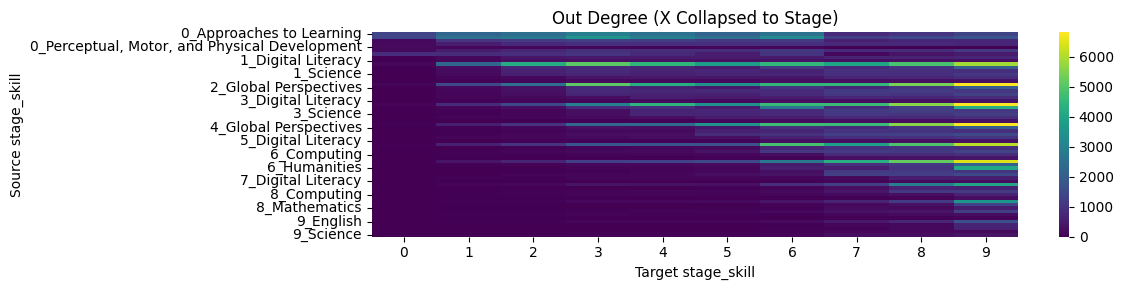

In [ ]:
def collapse_x_to_stages(matrix):
    # Extract stage from each column label (assuming format "stage_skill")
    stage_map = {col: col.split('_')[0] for col in matrix.columns}
    # Group by stage
    collapsed = matrix.groupby(stage_map, axis=1).sum()
    return collapsed
# Collapse x-axis to stages for heatmap
in_deg_stageX = collapse_x_to_stages(in_deg)
out_deg_stageX = collapse_x_to_stages(out_deg)
in_w_stageX = collapse_x_to_stages(in_w)
out_w_stageX = collapse_x_to_stages(out_w)

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

def plot_heatmap(matrix, title, wrap_width=15, y_fontsize=6):
    # Wrap y-axis labels
    y_labels = [textwrap.fill(label, wrap_width) for label in matrix.index]

    plt.figure(figsize=(4, 5))
    sns.heatmap(matrix, cmap='viridis', annot=False, cbar=True)

    plt.title(title)
    plt.xlabel('Target stage')
    plt.ylabel('Source stage skill')

    # Set wrapped y-axis labels with smaller font
    plt.yticks(ticks=[i+0.5 for i in range(len(y_labels))],
               labels=y_labels, fontsize=y_fontsize)

    plt.tight_layout()
    plt.savefig("out_degree.pdf")
    plt.show()

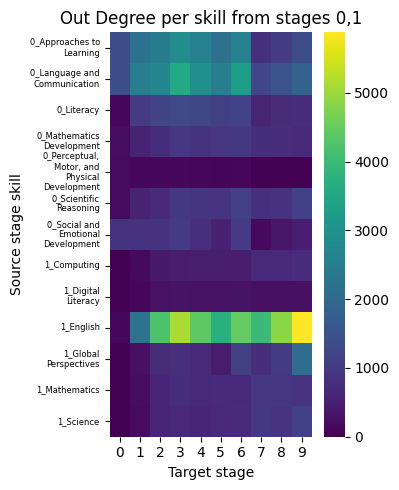

In [112]:
plot_heatmap(out_deg_stageX.iloc[:13,:], 'Out Degree per skill from stages 0,1')

In [5]:
with open("/datadrive/pavan/az_storage/CurLL_data/skill_graph/indicator_graph_edges_weighted.pkl", "rb") as f:
    DG = pickle.load(f)
    
from typing import Dict, List, Tuple, Optional
from tqdm import tqdm

def _safe_stage(x) -> Optional[int]:
    try:
        return int(x)
    except Exception:
        return None
    
# nodes_to_remove = [node for node, attrs in DG.nodes(data=True) if attrs.get("stage", 0) > 4]
# DG.remove_nodes_from(nodes_to_remove)

In [6]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Example: G is your directed skill graph
# Each node has: G.nodes[node]['stage']
# Each edge has: G.edges[u, v]['weight']

def stage_edge_heatmap(G, value='count'):
    """
    Create a heatmap of edges between stages.
    value='count' → number of edges
    value='avg_weight' → average weight of edges
    """
    # Collect all unique stages
    stages = sorted({G.nodes[n]['stage'] for n in G.nodes})
    stage_index = {stage: i for i, stage in enumerate(stages)}

    # Initialize matrix
    matrix = [[0 for _ in stages] for _ in stages]
    count_matrix = [[0 for _ in stages] for _ in stages]  # for averaging weights

    # Populate matrix
    for u, v, data in G.edges(data=True):
        s_from = G.nodes[u]['stage']
        s_to = G.nodes[v]['stage']
        w = data.get('weight', 1)

        if value == 'count':
            matrix[stage_index[s_from]][stage_index[s_to]] += 1
        elif value == 'avg_weight':
            matrix[stage_index[s_from]][stage_index[s_to]] += w
            count_matrix[stage_index[s_from]][stage_index[s_to]] += 1

    # Average weights if needed
    if value == 'avg_weight':
        for i in range(len(stages)):
            for j in range(len(stages)):
                if count_matrix[i][j] > 0:
                    matrix[i][j] /= count_matrix[i][j]

    # Convert to DataFrame for seaborn
    df = pd.DataFrame(matrix, index=[f"Stage {s}" for s in stages],
                      columns=[f"Stage {s}" for s in stages])

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=True, fmt=".2f" if value == 'avg_weight' else "d", cmap="Blues")
    plt.title(f"Stage-to-Stage Edge {'Count' if value == 'count' else 'Avg Weight'}")
    plt.xlabel("Target Stage")
    plt.ylabel("Source Stage")
    plt.tight_layout()
    plt.savefig("edge_graph.pdf")
    plt.show()

# Example usage:
# stage_edge_heatmap(G, value='count')       # for counts
# stage_edge_heatmap(G, value='avg_weight')  # for average weights


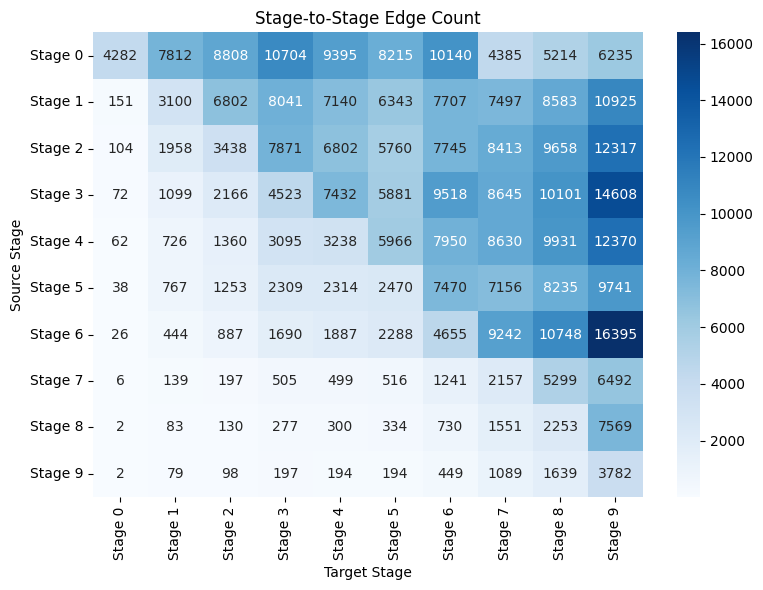

In [7]:
stage_edge_heatmap(DG, value='count')

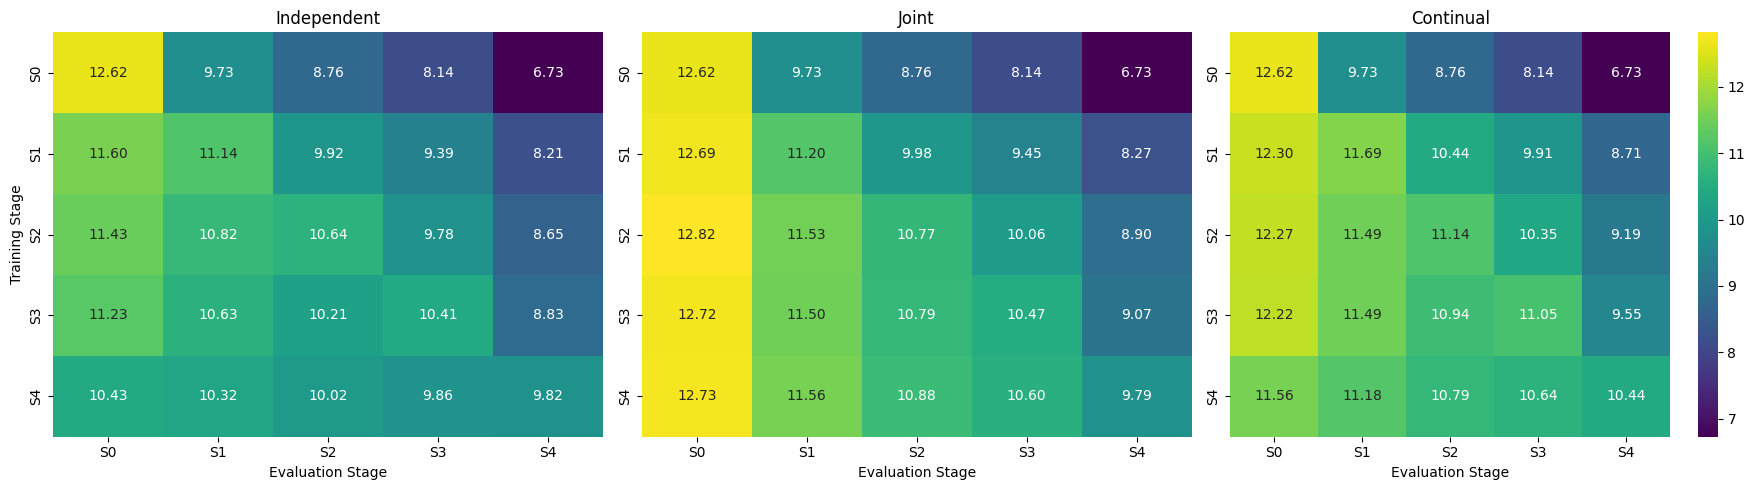

In [2]:
# New data from user
independent2 = np.array([
    [12.62, 9.73, 8.76, 8.14, 6.73],
    [11.60, 11.14, 9.92, 9.39, 8.21],
    [11.43, 10.82, 10.64, 9.78, 8.65],
    [11.23, 10.63, 10.21, 10.41, 8.83],
    [10.43, 10.32, 10.02, 9.86, 9.82]
])

joint2 = np.array([
    [12.62, 9.73, 8.76, 8.14, 6.73],
    [12.69, 11.20, 9.98, 9.45, 8.27],
    [12.82, 11.53, 10.77, 10.06, 8.90],
    [12.72, 11.50, 10.79, 10.47, 9.07],
    [12.73, 11.56, 10.88, 10.60, 9.79]
])

continual2 = np.array([
    [12.62, 9.73, 8.76, 8.14, 6.73],
    [12.30, 11.69, 10.44, 9.91, 8.71],
    [12.27, 11.49, 11.14, 10.35, 9.19],
    [12.22, 11.49, 10.94, 11.05, 9.55],
    [11.56, 11.18, 10.79, 10.64, 10.44]
])

# Create horizontal subplots with same scale
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
datasets2 = [independent2, joint2, continual2]
titles = ["Independent", "Joint", "Continual"]

# Shared scale
all_values2 = np.concatenate([d[~np.isnan(d)] for d in datasets2])
vmin2, vmax2 = all_values2.min(), all_values2.max()

for ax, data, title in zip(axes, datasets2, titles):
    mask = np.isnan(data)
    sns.heatmap(data, annot=True, fmt=".2f", cmap="viridis", mask=mask,
                xticklabels=[f"S{i}" for i in range(data.shape[1])],
                yticklabels=[f"S{i}" for i in range(data.shape[0])],
                vmin=vmin2, vmax=vmax2, cbar=(title=="Continual"), ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Evaluation Stage")
    if title == "Independent":
        ax.set_ylabel("Training Stage")
    else:
        ax.set_ylabel("")

plt.tight_layout()
plt.savefig("heatmaps.pdf")
plt.show()

#save the plot as pdf


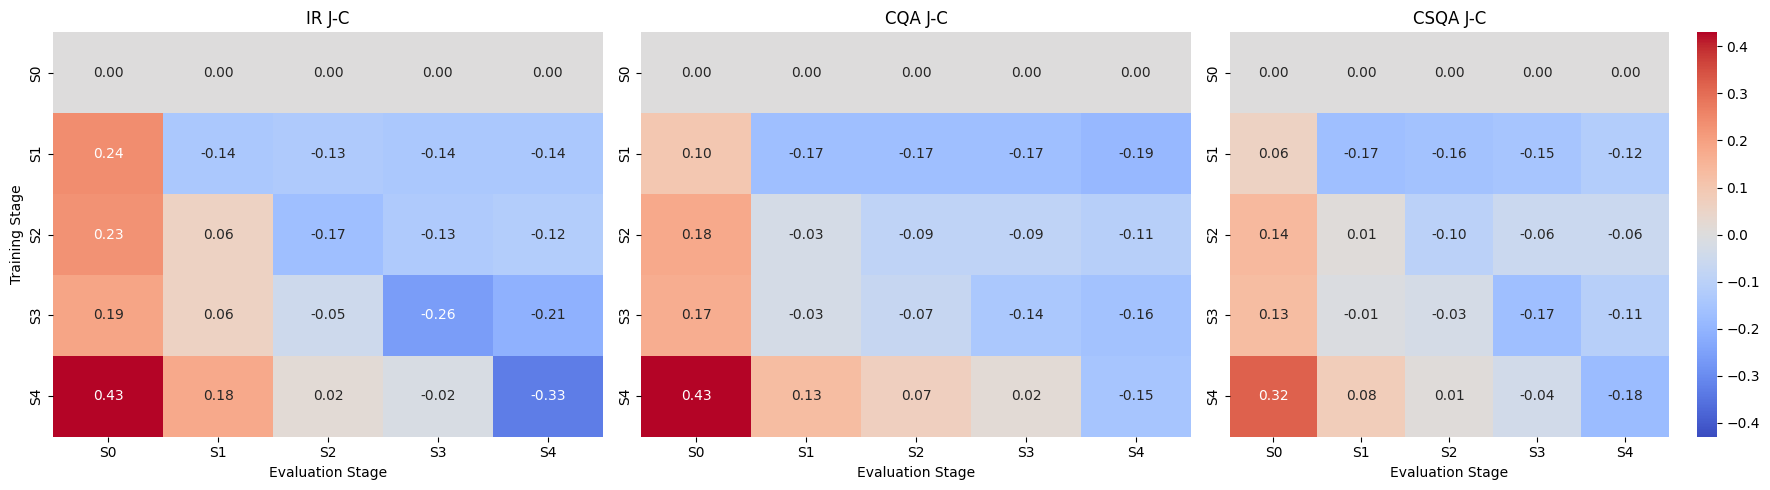

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data
IR_JC = np.array([
    [0.00, 0.00, 0.00, 0.00, 0.00],
    [0.24, -0.14, -0.13, -0.14, -0.14],
    [0.23, 0.06, -0.17, -0.13, -0.12],
    [0.19, 0.06, -0.05, -0.26, -0.21],
    [0.43, 0.18, 0.02, -0.02, -0.33]
])

CQA_JC = np.array([
    [0.00, 0.00, 0.00, 0.00, 0.00],
    [0.10, -0.17, -0.17, -0.17, -0.19],
    [0.18, -0.03, -0.09, -0.09, -0.11],
    [0.17, -0.03, -0.07, -0.14, -0.16],
    [0.43, 0.13, 0.07, 0.02, -0.15]
])

CSQA_JC = np.array([
    [0.00, 0.00, 0.00, 0.00, 0.00],
    [0.06, -0.17, -0.16, -0.15, -0.12],
    [0.14, 0.01, -0.10, -0.06, -0.06],
    [0.13, -0.01, -0.03, -0.17, -0.11],
    [0.32, 0.08, 0.01, -0.04, -0.18]
])

datasets = [IR_JC, CQA_JC, CSQA_JC]
titles = ["IR J-C", "CQA J-C", "CSQA J-C"]

# Find common scale
all_values = np.concatenate(datasets)
vmax = np.max(np.abs(all_values))

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, data, title in zip(axes, datasets, titles):
    sns.heatmap(data, annot=True, fmt=".2f", cmap="coolwarm", center=0,
                xticklabels=[f"S{i}" for i in range(data.shape[1])],
                yticklabels=[f"S{i}" for i in range(data.shape[0])],
                vmin=-vmax, vmax=vmax, cbar=(title == titles[-1]), ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Evaluation Stage")
    if title == titles[0]:
        ax.set_ylabel("Training Stage")
    else:
        ax.set_ylabel("")

plt.tight_layout()
plt.savefig("j_c.pdf")
plt.show()


In [267]:
a ={
    "system": "You are a developmental expert rating how well a child's response to a prompt demonstrates age-appropriate reasoning and language for a given developmental stage.\n\nYou will receive:\n- An **instruction** given to the child\n- The child's **response**\n- The child's **developmental stage** (0\u20139)\n- The child's **age group** (e.g., '0\u20135', '5\u201311', '11\u201314')\n\nYour job is to:\n1. **Rate the response on a scale from 1 to 5**, using the following criteria:\n   - **5 \u2013 Excellent:** The response fully addresses the instruction with clear, developmentally appropriate reasoning and language. It meets expectations for the stage with no major issues.\n   - **4 \u2013 Strong:** Mostly appropriate and coherent; minor gaps in clarity, depth, or completeness.\n   - **3 \u2013 Adequate:** A reasonable attempt that partially addresses the instruction; may be vague, brief, or contain small misunderstandings.\n   - **2 \u2013 Limited:** Weak or underdeveloped response; minimal reasoning or limited relevance to the instruction.\n   - **1 \u2013 Inadequate:** Response is off-topic, confusing, or clearly inappropriate for the stage.\n\n2. **Use stage-specific developmental expectations**:\n   - **Stage 0 (Age 5):** Very simple sentences, concrete ideas, focused on here and now\n   - **Stages 1\u20133 (Ages 6\u20138):** Simple reasoning, some past/future thinking, familiar examples\n   - **Stages 4\u20136 (Ages 9\u201311):** Logical structure, comparisons, abstract or hypothetical reasoning\n   - **Stages 7\u20139 (Ages 12\u201314):** Nuanced reasoning, multi-step thinking, advanced vocabulary\n\n3. **Evaluate:**\n   - Does the child\u2019s response meaningfully address the instruction?\n   - Is the language and reasoning developmentally appropriate for the stage?\n   - Is the response authentic and logically consistent?\n\n4. **Output Format:**\nOnly return the following dictionary:\n```json\n{{\n    \"rating\": <integer from 1 to 5>,\n    \"explanation\": \"<2\u20133 sentence rationale>\"\n}}\n```\nDo not add any other text or formatting. Only return the JSON object.",
    "user": "Evaluate the child's response to the instruction below based on the developmental stage and age group. Return a numerical rating (1\u20135) and a short explanation.\n\nInstruction: {instruction}\nResponse: {response}\nStage: {stage}\nAge group: {age_group}\nIndex: {q_index}\n\n**Output Format:**\nOnly return the following dictionary:\n```json\n{{\n    \"rating\": <integer from 1 to 5>,\n    \"explanation\": \"<2\u20133 sentence rationale>\"\n}}\n```\n"
}
print(a['system'])

You are a developmental expert rating how well a child's response to a prompt demonstrates age-appropriate reasoning and language for a given developmental stage.

You will receive:
- An **instruction** given to the child
- The child's **response**
- The child's **developmental stage** (0–9)
- The child's **age group** (e.g., '0–5', '5–11', '11–14')

Your job is to:
1. **Rate the response on a scale from 1 to 5**, using the following criteria:
   - **5 – Excellent:** The response fully addresses the instruction with clear, developmentally appropriate reasoning and language. It meets expectations for the stage with no major issues.
   - **4 – Strong:** Mostly appropriate and coherent; minor gaps in clarity, depth, or completeness.
   - **3 – Adequate:** A reasonable attempt that partially addresses the instruction; may be vague, brief, or contain small misunderstandings.
   - **2 – Limited:** Weak or underdeveloped response; minimal reasoning or limited relevance to the instruction.
   

In [268]:
print(a['user'])

Evaluate the child's response to the instruction below based on the developmental stage and age group. Return a numerical rating (1–5) and a short explanation.

Instruction: {instruction}
Response: {response}
Stage: {stage}
Age group: {age_group}
Index: {q_index}

**Output Format:**
Only return the following dictionary:
```json
{{
    "rating": <integer from 1 to 5>,
    "explanation": "<2–3 sentence rationale>"
}}
```

